### Лабораторна робота №3, Штучний інтелект в задачах обробки зображень
**Виконав**: студент групи ІП-11, Лошак Віктор Іванович<br>
**Перевірив**: Нікітін В.А.<br>
**Група студентів що виконувала роботу**: Шамков Іван, Кисельов Микита, Лошак Віктор<vr>

**Тема роботи**: Розмітка дорожньої лінії засобами OpenCV.<br>
**Мета роботи**: навчитися виконувати розмітку дорожних ліній на відео засобами OpenCV в режимі реального часу.

08.04.2024

**Завдання**:<br>
1. Проробити з будь-якою фотографією процедури, які описані в теоретичних відомостях:
    - Перетворіть зображення на відтінки сірого.
    - Застосуйте розмиття за Гаусом, щоб згладити зображення.
    - Використовуйте алгоритм Canny для виявлення країв.
    - Створіть маску з визначеними вершинами.
    - Застосуйте перетворення Гафа, щоб знайти лінії.
2. Зробити розпізнавання розмітки з будь-якого відеофайлу.

**Task**:<br>
1. Perform the procedures described in the theoretical information with any photo;
    - Convert your image to grayscale.
    - Apply Gaussian blur to smooth the image.
    - Use the Canny algorithm to detect edges.
    - Create a mask with defined vertices.
    - Apply the Hough Transform to find lines.
2. Do road markup recognition in any video file.

# 1. Проробити з будь-якою фотографією процедури, які описані в теоретичних відомостях;
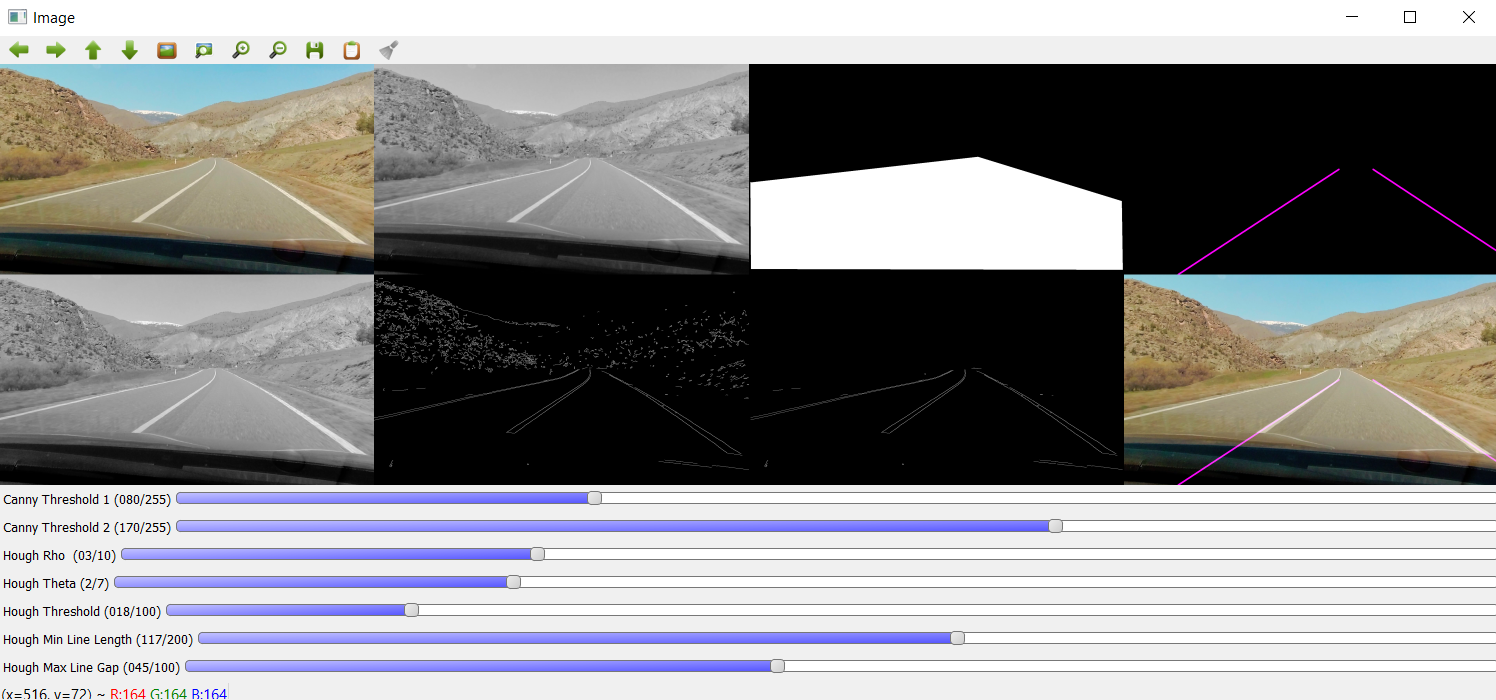

In [15]:
import cv2
import numpy as np
from imutils import resize

In [16]:
image_path = r"./input/screen_1.png"
img = cv2.imread(image_path)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
mask = np.zeros(img.shape[:2], dtype=np.uint8)
window_name = "Image"

In [17]:
def mouse_callback(event, x, y, flags, param):
    global roi_corners, current_dragging

    if event == cv2.EVENT_LBUTTONDOWN:
        # Start dragging and add a new corner
        current_dragging = True
        roi_corners.append((x, y))

    elif event == cv2.EVENT_MOUSEMOVE and current_dragging:
        # Update the current dragging corner's position
        roi_corners[-1] = (x, y)

    elif event == cv2.EVENT_LBUTTONUP:
        # Stop draggingq
        current_dragging = False

In [18]:
cv2.namedWindow(window_name, cv2.WINDOW_NORMAL)
cv2.resizeWindow(window_name, 1500, 1000)
cv2.setMouseCallback("Image", mouse_callback)

roi_corners = []
current_dragging = False


while True:
    temp_img = img.copy()
    
    if len(roi_corners) > 1:
        # Draw the ROI so far
        cv2.polylines(temp_img, [np.array(roi_corners)], isClosed=False, color=(0, 255, 0), thickness=2)
    
    cv2.imshow("Image", temp_img)
    
    key = cv2.waitKey(1) & 0xFF
    if key == ord("q"):
        break
    elif key == ord("c"):
        # Clear ROI
        roi_corners = []



if len(roi_corners) > 2:
    cv2.fillPoly(mask, [np.array(roi_corners)], 255)

# Apply the mask to the image or use it however you like
masked_image = cv2.bitwise_and(img, img, mask=mask)
cv2.imshow("Masked Image", masked_image)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [5]:
prev_x_bottom_pos = []
prev_x_upper_pos = []
prev_x_bottom_neg = []
prev_x_upper_neg = []

def reject_outliers(data, m=2):
    return data[abs(data - np.mean(data)) < m * np.std(data)]

def draw_lines(img, lines, color=[255, 0, 255], thickness=7):
    global prev_x_bottom_pos, prev_x_upper_pos, prev_x_bottom_neg, prev_x_upper_neg
    
    if lines is None:
        return
    
    height, width = img.shape[:2]
    y_bottom = height  # Bottom of the image
    y_upper = int(height * 0.5)  # Some distance from the top

    x_bottom_pos = []
    x_upper_pos = []
    x_bottom_neg = []
    x_upper_neg = []

    for line in lines:
        for x1, y1, x2, y2 in line:
            if x2 == x1:
                continue  # Ignore a vertical line
            slope = (y2 - y1) / (x2 - x1)
            intercept = y1 - slope * x1
            if 0.3 < slope < 1.5:  # Adjust these values based on your images
                x_bottom_pos.append((y_bottom - intercept) / slope)
                x_upper_pos.append((y_upper - intercept) / slope)
            elif -1.5 < slope < -0.3:  # Adjust these values based on your images
                x_bottom_neg.append((y_bottom - intercept) / slope)
                x_upper_neg.append((y_upper - intercept) / slope)

    # Reject outliers
    x_bottom_pos = reject_outliers(np.array(x_bottom_pos))
    x_upper_pos = reject_outliers(np.array(x_upper_pos))
    x_bottom_neg = reject_outliers(np.array(x_bottom_neg))
    x_upper_neg = reject_outliers(np.array(x_upper_neg))

    # Update global variables if current frame has valid data
    if len(x_bottom_pos) > 0 and not np.isnan(np.mean(x_bottom_pos)):
        prev_x_bottom_pos = x_bottom_pos
    if len(x_upper_pos) > 0 and not np.isnan(np.mean(x_upper_pos)):
        prev_x_upper_pos = x_upper_pos
    if len(x_bottom_neg) > 0 and not np.isnan(np.mean(x_bottom_neg)):
        prev_x_bottom_neg = x_bottom_neg
    if len(x_upper_neg) > 0 and not np.isnan(np.mean(x_upper_neg)):
        prev_x_upper_neg = x_upper_neg
    
    # Use previous frame data if current frame data is invalid
    if len(x_bottom_pos) == 0 or np.isnan(np.mean(x_bottom_pos)):
        x_bottom_pos = prev_x_bottom_pos
    if len(x_bottom_neg) == 0 or np.isnan(np.mean(x_bottom_neg)):
        x_bottom_neg = prev_x_bottom_neg
    if len(x_upper_pos) == 0 or np.isnan(np.mean(x_upper_pos)):
        x_upper_pos = prev_x_upper_pos
    if len(x_upper_neg) == 0 or np.isnan(np.mean(x_upper_neg)):
        x_upper_neg = prev_x_upper_neg

    # Draw the lines if we have valid data points
    if len(x_bottom_pos) > 0 and len(x_upper_pos) > 0:
        cv2.line(img, (int(np.mean(x_bottom_pos)), y_bottom), (int(np.mean(x_upper_pos)), y_upper), color, thickness)
    if len(x_bottom_neg) > 0 and len(x_upper_neg) > 0:
        cv2.line(img, (int(np.mean(x_bottom_neg)), y_bottom), (int(np.mean(x_upper_neg)), y_upper), color, thickness)


In [6]:

cv2.namedWindow(window_name)

cv2.createTrackbar("Canny Threshold 1", window_name, 80, 255, lambda x: None)
cv2.createTrackbar("Canny Threshold 2", window_name, 170, 255, lambda x: None)
cv2.createTrackbar("Hough Rho", window_name, 3, 10, lambda x: None)
cv2.createTrackbar("Hough Theta", window_name, 2, 7, lambda x: None)
cv2.createTrackbar("Hough Threshold", window_name, 18, 100, lambda x: None)
cv2.createTrackbar("Hough Min Line Length", window_name, 117, 200, lambda x: None)
cv2.createTrackbar("Hough Max Line Gap", window_name, 45, 100, lambda x: None)

while True:
    canny_t1 = max(1, cv2.getTrackbarPos("Canny Threshold 1", window_name))
    canny_t2 = max(1, cv2.getTrackbarPos("Canny Threshold 2", window_name))
    rho = max(1, cv2.getTrackbarPos("Hough Rho", window_name))
    theta = max(1, cv2.getTrackbarPos("Hough Theta", window_name)) * np.pi / 180
    hough_threshold = max(1, cv2.getTrackbarPos("Hough Threshold", window_name))
    min_line_length = max(1, cv2.getTrackbarPos("Hough Min Line Length", window_name))
    max_line_gap = max(1, cv2.getTrackbarPos("Hough Max Line Gap", window_name))

    clear_img = img.copy()
    img_gray = cv2.cvtColor(clear_img, cv2.COLOR_BGR2GRAY)
    blured = cv2.GaussianBlur(img_gray, (5, 5), 0)
    edges = cv2.Canny(blured, canny_t1, canny_t2)

    masked_edges = cv2.bitwise_and(edges, mask)

    lines = cv2.HoughLinesP(masked_edges, rho, theta, hough_threshold, np.array([]),
                            minLineLength=min_line_length, maxLineGap=max_line_gap)
    img_lines = np.zeros_like(img)
    draw_lines(img_lines, lines)

    # forming the grid for the display of results.
    img_pairs = [
        (clear_img, cv2.cvtColor(img_gray, cv2.COLOR_GRAY2BGR)),
        (cv2.cvtColor(blured, cv2.COLOR_GRAY2BGR), cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)),
        (cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR), cv2.cvtColor(masked_edges, cv2.COLOR_GRAY2BGR)),
        (img_lines, cv2.addWeighted(clear_img, 1, img_lines, 1, 0))
    ]
    img_stacks = [np.vstack(pair) for pair in img_pairs]
    combined_img = resize(np.hstack(img_stacks), width=1500)
    cv2.imshow(window_name, combined_img)

    if cv2.waitKey(1) == ord("q"):
        break

cv2.destroyAllWindows()

# 2. Зробити розпізнавання розмітки з будь-якого відеофайлу.
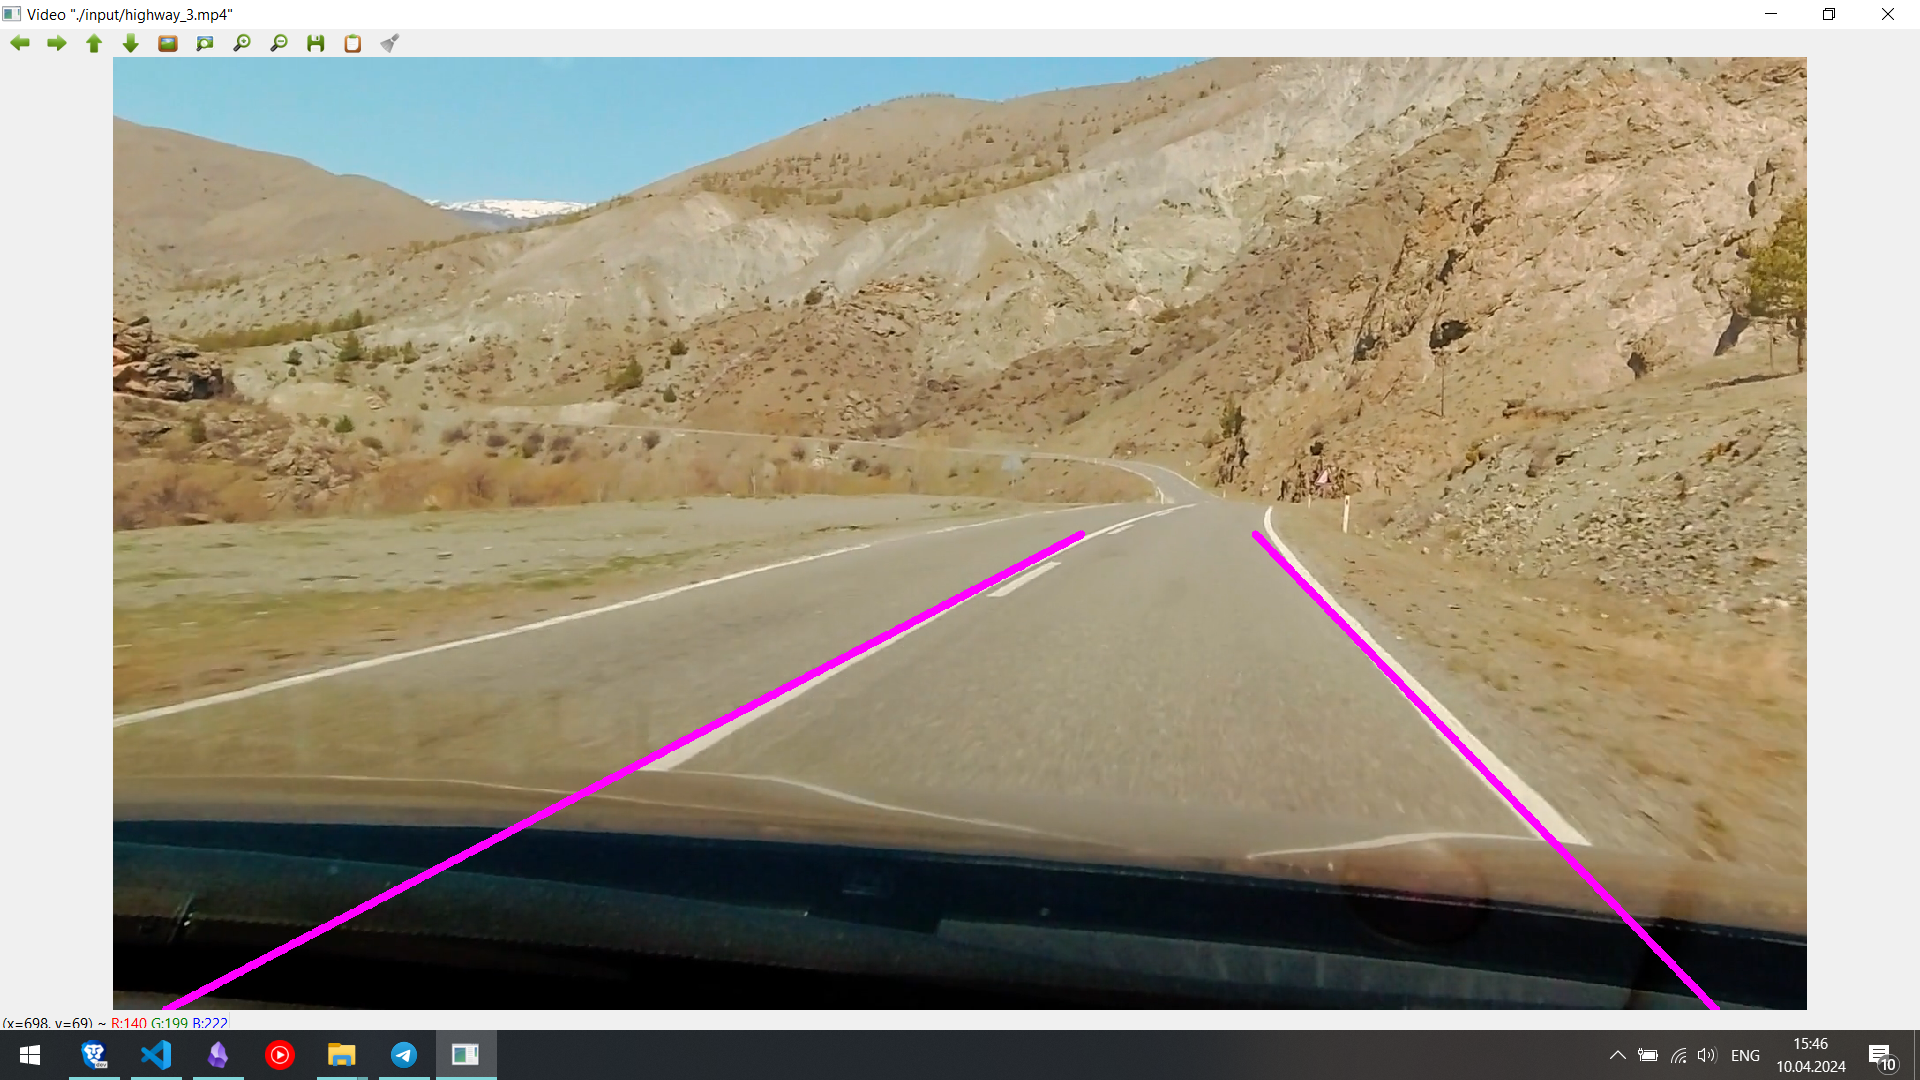

In [19]:
def video_frame_generator(video_path):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise FileNotFoundError("Could not open video file...")
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            yield frame, frame_gray
    finally:
        cap.release()

In [20]:
def preprocess(
    img, img_gray,
    kernel=(5, 5),
    canny_t=(80, 170),
    rho=3,
    theta=2*np.pi / 180,
    threshold=18,
    min_line_len=117,
    max_line_gap=45
):
    blured = cv2.GaussianBlur(img_gray, kernel, 0)
    edges = cv2.Canny(blured, canny_t[0], canny_t[1])
    masked_edges = cv2.bitwise_and(edges, mask)
    
    lines = cv2.HoughLinesP(
        masked_edges,
        rho,
        theta,
        threshold,
        np.array([]),
        minLineLength=min_line_len,
        maxLineGap=max_line_gap
    )

    draw_lines(img, lines)
    
    return img

In [23]:
video_file_path = r"./input/highway_3.mp4"

for color_frame, gray_frame in video_frame_generator(video_file_path):
    cv2.imshow(f"./output", preprocess(color_frame, gray_frame))
    if cv2.waitKey(1) == ord("q"):
        break
    if cv2.waitKey(1) == ord("s"):
        cv2.imwrite("./output", color_frame)
        
cv2.waitKey(0)
cv2.destroyAllWindows()

#### Control questions:
1. Чому краще обробляти сіре зображення?
2. Навіщо робити розмиття зображення перед розпізнаванням?
3. Що таке алгоритм Кенні?
4. Що таке перетворення Хафа?
5. Яка мета маски?<br>

**Answers:**<br>
1. Обробка сірого зображення зменшує обчислювальну складність, оскільки сіре зображення має тільки один канал порівняно з трьома в кольоровому, і це підсилює контрасти, полегшуючи виявлення країв.
2. Розмиття допомагає зменшити шум і непотрібні деталі на зображенні, що поліпшує точність виявлення країв.
3. Алгоритм Кенні – це метод виявлення країв, що включає згладжування зображення, визначення інтенсивності країв і застосування подвійного порогу для вибіркового виявлення сильних країв.
4. Перетворення Хафа використовується для виявлення прямих ліній, кіл та інших форм на зображенні, перетворюючи точки в простір параметрів, де лінії представлені як точки.
5. Маска використовується для фокусування обробки на певній області зображення, ігноруючи всі інші частини, що не є важливими для задачі.